# Evaluation of image synthetization from privacy enhanced templates (PEMIU)

- Image recreation of privacy protected (PEMIU) templates
- Different block sizes for PEMIU shuffle: 16, 32, 64, 128
- Cosine similarity between
  - bona fide target embedding & input embedding
  - bona fide target embedding & embedding from synthesized image

In [1]:
# System
import os

# Data preparation
import pandas as pd
import numpy as np

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8
# sns.set_style('whitegrid')

In [2]:
logs = [f"../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/logs/sample_images_log_pemiu{block_size}.csv"
        for block_size in ["16", "32", "64", "128"]]
cosine_similarity_pemiu = "../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/cosine_similarity/cos_sim_samples_pemiu.csv"
cosine_similarity_unprotected = "../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/cosine_similarity/cos_sim_samples_unprotected.csv"
samples_paths = [f"../recreate_icip2022_face_reconstruction/experiments/experiment_7_model1_pemiu_block_sizes/sample_images_pemiu{block_size}" 
                 for block_size in ["16", "32", "64", "128"]]

# Get filepaths of all LFW images
all_files_list = []
for subdir, dirs, files in os.walk(os.path.join("../data/lfw_align/")):
    for element in files:
        file = os.path.join(subdir, element)
        all_files_list.append(file)

In [3]:
block_sizes = ["16", "32", "64", "128"]

# Prepare data frame
df = pd.DataFrame()
df['files'] = all_files_list
df_pemiu = pd.read_csv(cosine_similarity_pemiu)
df['filename'] = df_pemiu['filename']

# Add cos_sim calculations with varying block sizes to dataframe
for index, blocksize in enumerate(block_sizes):
    df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}'] = df_pemiu[f'cos_sim_pemiu{blocksize}_vs_real']
    
# Add cos_sim of unprotected synthesized images
df[f'cos_sim_bonafide_synthesized_unprotected'] = pd.read_csv(cosine_similarity_unprotected)['cos_sim_reconstructed_vs_real']

In [4]:
df

,files,filename,cos_sim_bonafide_synthesized_pemiu16,cos_sim_bonafide_synthesized_pemiu32,cos_sim_bonafide_synthesized_pemiu64,cos_sim_bonafide_synthesized_pemiu128,cos_sim_bonafide_synthesized_unprotected
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...,Aaron_Eckhart_0001,-0.052590,0.004599,0.136084,0.339503,0.419634
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...,Aaron_Guiel_0001,-0.049463,0.069386,0.044840,0.182340,0.271073
2,../data/lfw_align/Aaron_Patterson/Aaron_Patter...,Aaron_Patterson_0001,0.138131,-0.021905,-0.047909,0.132808,0.339001
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,Aaron_Peirsol_0001,-0.038181,0.025382,-0.025505,0.059249,0.338860
4,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,Aaron_Peirsol_0002,-0.022854,-0.087568,-0.048832,0.115987,0.447910
...,...,...,...,...,...,...,...
13228,../data/lfw_align/Zorica_Radovic/Zorica_Radovi...,Zorica_Radovic_0001,0.027086,0.137468,0.166098,-0.000032,0.622873
13229,../data/lfw_align/Zulfiqar_Ahmed/Zulfiqar_Ahme...,Zulfiqar_Ahmed_0001,0.051955,0.184038,0.110403,0.043946,0.497823
13230,../data/lfw_align/Zumrati_Juma/Zumrati_Juma_00...,Zumrati_Juma_0001,0.082374,0.118819,0.189246,0.062893,0.382784
13231,../data/lfw_align/Zurab_Tsereteli/Zurab_Tseret...,Zurab_Tsereteli_0001,-0.046535,-0.069515,0.082563,0.109777,0.582532


## Normalization

 Normalize cosine distance to range (0, 1)

In [5]:
# Set normalization range to include values from genuine and impostor comparisons
min_max_values = [[0.2430551121288237],
 [-0.0050609096468108294],
 [0.9729986512423155],
 [0.9729986512423154],
 [0.1912166066597454],
 [-0.23413056292959689],
 [0.3636036840601125],
 [0.30872918671248395]]

# Simplify gathering of columns by using a mask
mask = df.columns.str.contains('cos_sim_*')

# Step 1: Set limits of normalization scale to all columns within the mask by finding min, max values
min_max_values_new = [array.agg(['min', 'max']) for array in [df.loc[:, mask]]]
min_max_values_new = np.array(min_max_values_new).reshape(-1, 1).tolist()
min_max_values = min_max_values + min_max_values_new

# Step 2: Set normalization scale
scaler = MinMaxScaler()
scaler.fit(min_max_values)

# Step 3: Apply normalization to all columns within the mask
# Append extension "_normalized" to the new column name
for column in df.loc[:, mask]:
    df[f'{column}_normalized'] = scaler.transform(df[column].values.reshape(-1, 1))

In [6]:
# df column names overview
print(('\n').join(df.columns.tolist()))

files
filename
cos_sim_bonafide_synthesized_pemiu16
cos_sim_bonafide_synthesized_pemiu32
cos_sim_bonafide_synthesized_pemiu64
cos_sim_bonafide_synthesized_pemiu128
cos_sim_bonafide_synthesized_unprotected
cos_sim_bonafide_synthesized_pemiu16_normalized
cos_sim_bonafide_synthesized_pemiu32_normalized
cos_sim_bonafide_synthesized_pemiu64_normalized
cos_sim_bonafide_synthesized_pemiu128_normalized
cos_sim_bonafide_synthesized_unprotected_normalized


In [7]:
df

,files,filename,cos_sim_bonafide_synthesized_pemiu16,cos_sim_bonafide_synthesized_pemiu32,cos_sim_bonafide_synthesized_pemiu64,cos_sim_bonafide_synthesized_pemiu128,cos_sim_bonafide_synthesized_unprotected,cos_sim_bonafide_synthesized_pemiu16_normalized,cos_sim_bonafide_synthesized_pemiu32_normalized,cos_sim_bonafide_synthesized_pemiu64_normalized,cos_sim_bonafide_synthesized_pemiu128_normalized,cos_sim_bonafide_synthesized_unprotected_normalized
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...,Aaron_Eckhart_0001,-0.052590,0.004599,0.136084,0.339503,0.419634,0.200561,0.245139,0.347631,0.506194,0.568656
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...,Aaron_Guiel_0001,-0.049463,0.069386,0.044840,0.182340,0.271073,0.202998,0.295640,0.276507,0.383687,0.452854
2,../data/lfw_align/Aaron_Patterson/Aaron_Patter...,Aaron_Patterson_0001,0.138131,-0.021905,-0.047909,0.132808,0.339001,0.349227,0.224479,0.204209,0.345078,0.505803
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,Aaron_Peirsol_0001,-0.038181,0.025382,-0.025505,0.059249,0.338860,0.211793,0.261339,0.221673,0.287739,0.505694
4,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,Aaron_Peirsol_0002,-0.022854,-0.087568,-0.048832,0.115987,0.447910,0.223740,0.173296,0.203490,0.331966,0.590697
...,...,...,...,...,...,...,...,...,...,...,...,...
13228,../data/lfw_align/Zorica_Radovic/Zorica_Radovi...,Zorica_Radovic_0001,0.027086,0.137468,0.166098,-0.000032,0.622873,0.262668,0.348710,0.371027,0.241530,0.727079
13229,../data/lfw_align/Zulfiqar_Ahmed/Zulfiqar_Ahme...,Zulfiqar_Ahmed_0001,0.051955,0.184038,0.110403,0.043946,0.497823,0.282053,0.385010,0.327613,0.275810,0.629604
13230,../data/lfw_align/Zumrati_Juma/Zumrati_Juma_00...,Zumrati_Juma_0001,0.082374,0.118819,0.189246,0.062893,0.382784,0.305765,0.334173,0.389070,0.290579,0.539931
13231,../data/lfw_align/Zurab_Tsereteli/Zurab_Tseret...,Zurab_Tsereteli_0001,-0.046535,-0.069515,0.082563,0.109777,0.582532,0.205281,0.187368,0.305912,0.327125,0.695634


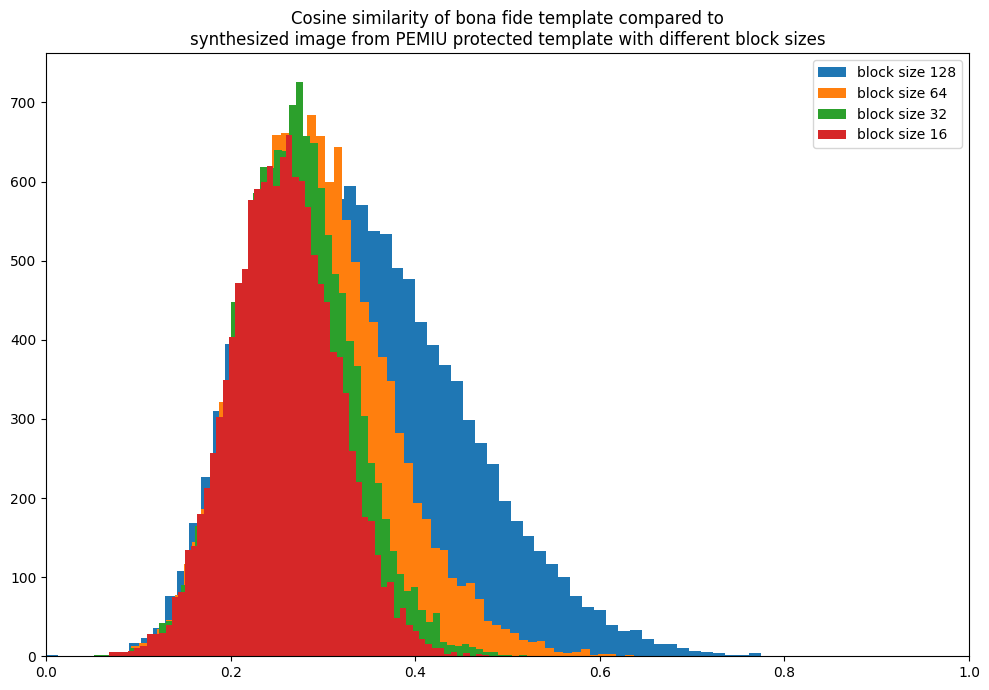

In [8]:
fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)
# todo: Add comment
for blocksize in block_sizes[::-1]:  # reverse block_sizes for stacked visualization
    ax.hist(df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'], bins = 60, label=f"block size {blocksize}")

ax.legend()
ax.set_title("Cosine similarity of bona fide template compared to\nsynthesized image from PEMIU protected template with different block sizes")
plt.xlim([0, 1])
    
# Show plot
plt.show()

## Include thresholds

Import thresholds from pyeer reports

In [9]:
block_size = 16
df_th = pd.read_csv(f"../evaluation/pyeer_lfwview2_pemiu{block_size}_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
df_th.drop(df_th.index[1:], inplace=True)
df_th.index.name = 'index'
df_th = df_th.T

for _, block_size in enumerate(["16", "32", "64", "128"]):
    df_temp = pd.read_csv(f"../evaluation/pyeer_lfwview2_pemiu{block_size}_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
    df_temp.drop(df_temp.index[2:], inplace=True)
    df_temp.drop(df_temp.index[:-1], inplace=True)
    df_temp = df_temp.replace({'Experiment ID': "Genuine PEMIU Reconstructed"}, f"Genuine Pemiu{block_size} Reconstructed")
    df_temp = df_temp.T
    df_th = pd.concat([df_th, df_temp], axis=1)
    
df_th = df_th.T
df_th

,Experiment ID,GMean,GSTD,IMean,ISTD,Sensitivity index (d'),AUC,J-Index,J-Index_TH,MCC,...,FMR20,FMR10,ZeroFNMR,EER_TH,ZeroFMR_TH,FMR1000_TH,FMR100_TH,FMR20_TH,FMR10_TH,ZeroFNMR_TH
0,Unprotected,0.787249,0.084698,0.196099,0.059407,8.080924,0.99924,0.995667,0.434108,0.995676,...,0.002,0.001667,0.537333,0.364969,0.467973,0.399035,0.335165,0.296682,0.273044,0.189764
1,Genuine Pemiu16 Reconstructed,0.791736,0.072993,0.560823,0.015309,4.378576,0.998104,0.988,0.606658,0.988056,...,0.005,0.004,0.896,0.597289,0.609544,0.605746,0.597029,0.587479,0.580623,0.541488
1,Genuine Pemiu32 Reconstructed,0.787972,0.081087,0.417859,0.01859,6.291776,0.998855,0.995,0.485574,0.995009,...,0.003667,0.003,0.886333,0.471171,0.498946,0.485574,0.464521,0.44957,0.441655,0.395306
1,Genuine Pemiu64 Reconstructed,0.787541,0.082984,0.319744,0.022999,7.682623,0.999323,0.995667,0.434108,0.995676,...,0.002333,0.002,0.493667,0.392258,0.467973,0.410006,0.38236,0.358164,0.349175,0.318884
1,Genuine Pemiu128 Reconstructed,0.787372,0.083909,0.257972,0.030459,8.387081,0.999437,0.995667,0.434108,0.995676,...,0.002333,0.001667,0.536667,0.364969,0.467973,0.399035,0.339667,0.310835,0.296829,0.252745


## Plot system thresholds and attack on PEMIU enhanced templates using model 1

tbd

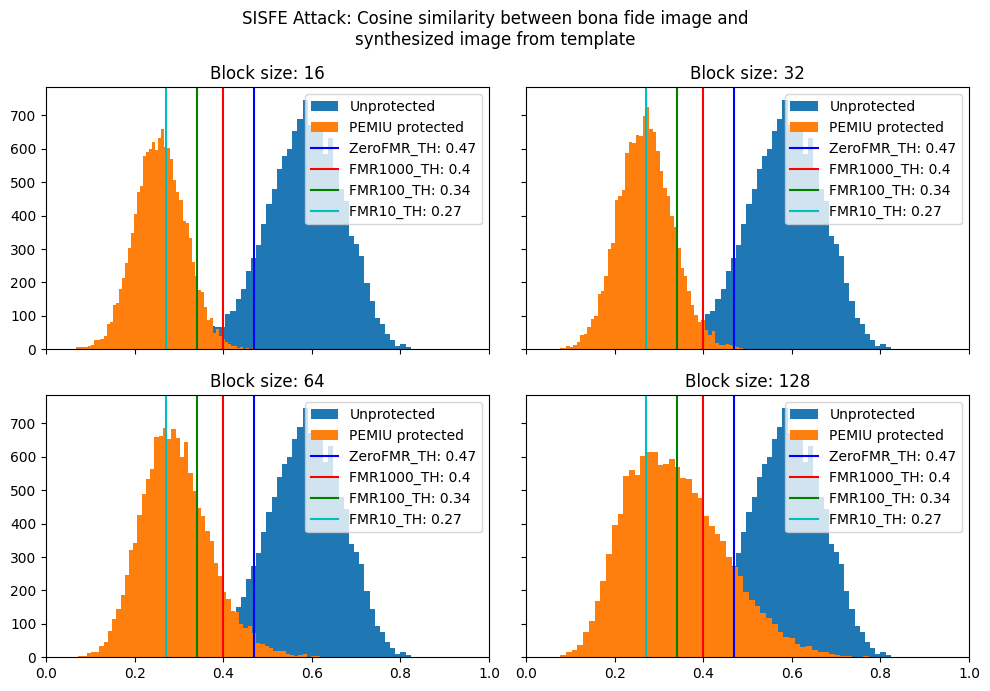

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
fig.suptitle("SISFE Attack: Cosine similarity between bona fide image and\nsynthesized image from template")

# Settings
labels_th = ['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
colors = ["b", "r", "g", "c"]

for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    ax.hist(df[f'cos_sim_bonafide_synthesized_unprotected_normalized'], bins = 60, label=f"Unprotected")
    ax.hist(df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'], bins = 60, label=f"PEMIU protected")
    ax.set_title(f"Block size: {blocksize}")
    ax.set_xlim(0, 1)
    ax.label_outer()
    # Thresholds
    for index, row in enumerate(df_th[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
        ax.axvline(x = round(((df_th[row].values[0])), 2), color = colors[index], label = f'{labels_th[index]}: {round(df_th[row].values[0], 2)}')
    ax.legend()

#for i, title in enumerate(['Bona Fide Comparison Unprotected', 
#                           f'Bona Fide Comparison PEMIU Protected (block size 16)',
#                           f'Bona Fide Comparison PEMIU Protected (block size 32)',
#                           f'Bona Fide Comparison PEMIU Protected (block size 64)',
#                           f'Bona Fide Comparison PEMIU Protected (block size 128)',]):

# Render plot
plt.xlim([0, 1])
plt.show()

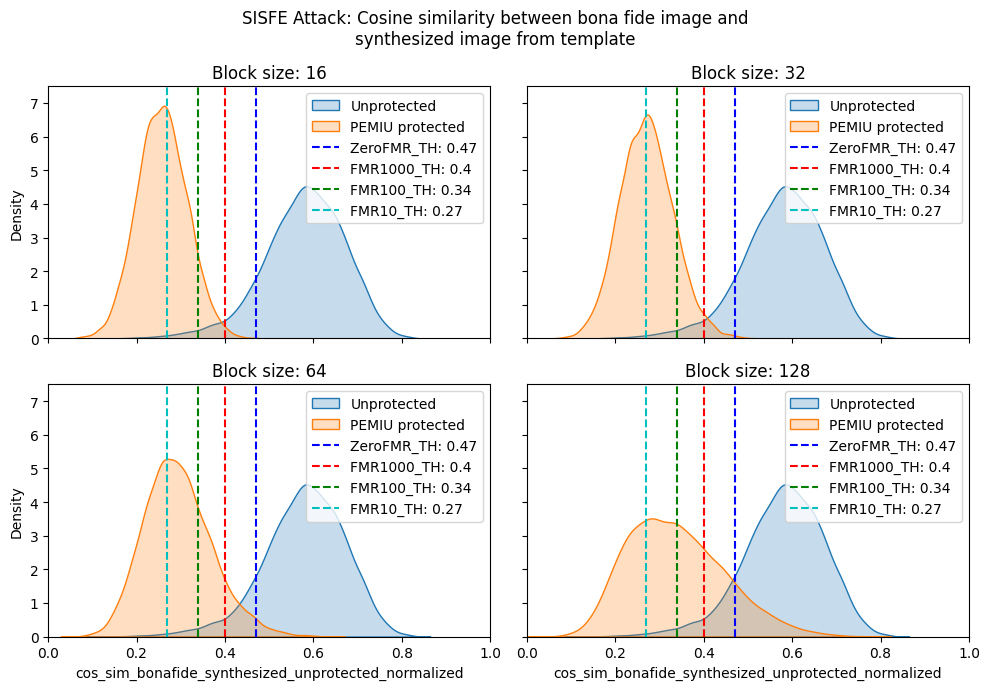

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                        figsize = (10, 7),
                        tight_layout = True)

# Title
fig.suptitle("SISFE Attack: Cosine similarity between bona fide image and\nsynthesized image from template")

# Settings
labels_th = ['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
colors = ["b", "r", "g", "c"]

for i, (blocksize, ax) in enumerate(zip(block_sizes, fig.get_axes())):
    sns.kdeplot(df[f'cos_sim_bonafide_synthesized_unprotected_normalized'], ax=ax, label=f"Unprotected", fill=True)
    sns.kdeplot(df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'], ax=ax, label=f"PEMIU protected", fill=True)
    ax.set_title(f"Block size: {blocksize}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7.5)
    ax.label_outer()
    # Thresholds
    for index, row in enumerate(df_th[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
        ax.axvline(x = round(((df_th[row].values[0])), 2), 
                   color = colors[index], 
                   linestyle="--",
                   label = f'{labels_th[index]}: {round(df_th[row].values[0], 2)}')
    ax.legend()

# Render plot
plt.xlim([0, 1])
plt.show()

In [12]:
for blocksize in block_sizes:
    print(f"\nBlock size: {blocksize}")
    print("--------------")
    for index, row in enumerate(df_th[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']]):
        print(f"{labels_th[index]}:\t{round(df_th[row].values[0], 2)}")
        num = len(df[df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'] > round(df_th[row].values[0], 2)])
        print(f"\t\tNumber of images above threshold: " \
              f"{num}\n" \
              f"\t\tPercent of images: {round((num / len(df) * 100), 2)} %")


Block size: 16
--------------
ZeroFMR_TH:	0.47
		Number of images above threshold: 2
		Percent of images: 0.02 %
FMR1000_TH:	0.4
		Number of images above threshold: 93
		Percent of images: 0.7 %
FMR100_TH:	0.34
		Number of images above threshold: 981
		Percent of images: 7.41 %
FMR10_TH:	0.27
		Number of images above threshold: 5407
		Percent of images: 40.86 %

Block size: 32
--------------
ZeroFMR_TH:	0.47
		Number of images above threshold: 20
		Percent of images: 0.15 %
FMR1000_TH:	0.4
		Number of images above threshold: 293
		Percent of images: 2.21 %
FMR100_TH:	0.34
		Number of images above threshold: 1636
		Percent of images: 12.36 %
FMR10_TH:	0.27
		Number of images above threshold: 6544
		Percent of images: 49.45 %

Block size: 64
--------------
ZeroFMR_TH:	0.47
		Number of images above threshold: 277
		Percent of images: 2.09 %
FMR1000_TH:	0.4
		Number of images above threshold: 1188
		Percent of images: 8.98 %
FMR100_TH:	0.34
		Number of images above threshold: 3369
		Perce

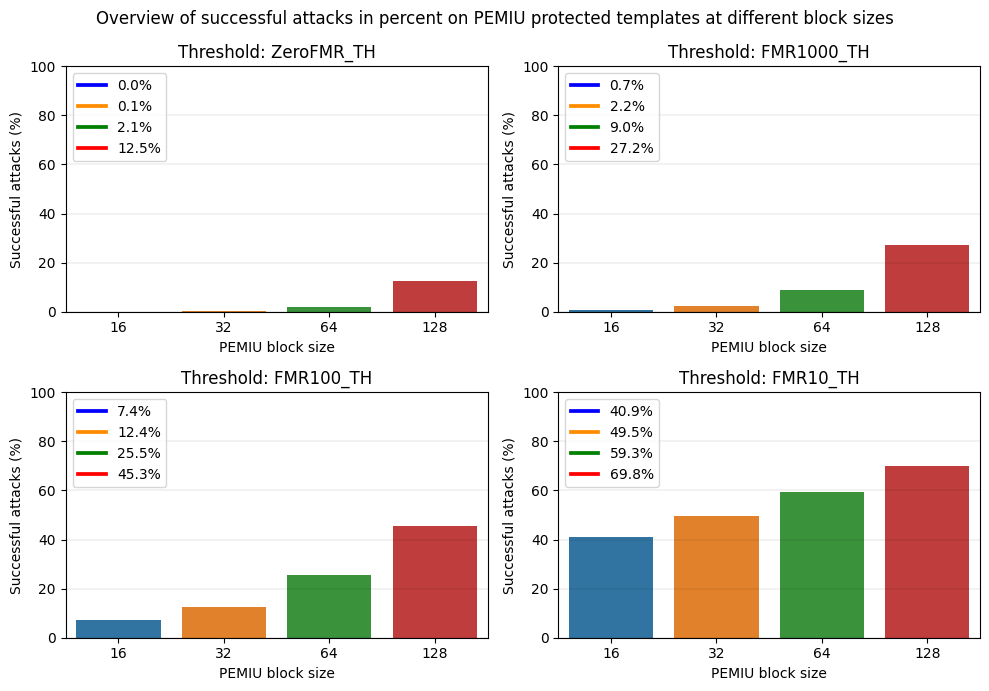

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 7), tight_layout = True)

# Title
fig.suptitle("Overview of successful attacks in percent on PEMIU protected templates at different block sizes")

# Settings
labels_th = ['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']

# 
for i, (row, ax) in enumerate(zip(df_th[['ZeroFMR_TH', 'FMR1000_TH', 'FMR100_TH', 'FMR10_TH']], fig.get_axes())):
    successful_attacks = []
    for blocksize in block_sizes:
        num = len(df[df[f'cos_sim_bonafide_synthesized_pemiu{blocksize}_normalized'] > round(df_th[row].values[0], 2)])
        num = round((num / len(df) * 100), 2)
        successful_attacks.append(num)
    ax.set_title(f"Threshold: {labels_th[i]}")
    ax.set_ylim(0, 100)
    ax.grid(visible=True, which='major', color='black', linewidth=0.075)
    ax.set_ylabel("Successful attacks (%)")
    ax.set_xlabel("PEMIU block size")
    sns.barplot(x=block_sizes, y=successful_attacks, ax=ax)
    ax.legend(labels=[f"{round(x, 1)}%" for x in successful_attacks], loc=2)
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('darkorange')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('red')

# Render plot
plt.show()